In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
import os
from tqdm import tqdm
import math
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
import xml.etree.ElementTree as etree
import time
from wordcloud import WordCloud

import json
with open('Data/stop_words_english.json') as json_file:
    stops = json.load(json_file)

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [6]:
def post_to_words( post_text, stopwords_lem=True):
    # 2. Remove non-letters
    post_text = re.sub(r"(\\n)|(\.\\n)|(\'\w+)|(http*\S+)|[^\w\s\.,#+-]", " ", post_text)
    post_text = re.sub(r"(\.\s)|(\.$)|(,\s)|(\s#\s)|(\'\w+)|(\s\-\s)", " ", post_text)
    post_text = re.sub(r"(\s-?\+?\d{0,4}\s)", " ", post_text)
    post_text = re.sub(r"\s+", " ", post_text)
    #
    # 3. Convert to lower case, split into individual words
    words = post_text.lower().split()
    #
    if stopwords_lem :
        # 4. In Python, searching a set is much faster than searching
        # a list, so convert the stop words to a set
        # 5. Remove stop words
        words = [w for w in words if not w in stops]
        # 6. Join the words back into one string separated by space,
        # and return the result.
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join( words )

In [5]:
def clean_html_body(x):
    soup = BeautifulSoup(x)
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return soup.get_text()

In [3]:
def clean_tags(x):
    tag_iter = []
    for tag in x:
        if tag in Tags_name_list:
            tag_iter.append(tag)
    return tag_iter

In [4]:
def split_tags(x):
    return re.sub(r"><", " ", re.sub(r"^<|>$", "", x)).split()

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Préparation des données

### de l'XML au CSV

In [24]:
outro = "</posts>"
it = 0
valid = 0
count = 1
start_time = time.time()
with open('Data/Posts.xml', 'r', encoding='utf8') as inputFile :
    outputLine = []
    intro = []
    intro.append(inputFile.readline())
    intro.append(inputFile.readline())
    outputLine.extend(intro)
    for inputLine in inputFile :
        if 'PostTypeId="1"' in inputLine :
            outputLine.append(inputLine)
            valid += 1
            if valid % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes de gardées sur {:,}. ça avance    ".format(valid, it) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
            if valid % 1000000 == 0 :
                outputLine.append(outro)
                interval = time.time() - start_time
                with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
                    outputFile.writelines(outputLine)
                print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")
                count += 1
                outputLine = []
                outputLine.extend(intro)
        it += 1
    outputLine.append(outro)
    interval = time.time() - start_time
    with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
        outputFile.writelines(outputLine)
    print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")

100,000 lignes de gardées sur 448,943. ça avance    0:2.683 temps passé
200,000 lignes de gardées sur 835,699. ça avance    0:4.889 temps passé
300,000 lignes de gardées sur 1,192,225. ça avance    0:6.918 temps passé
400,000 lignes de gardées sur 1,546,639. ça avance    0:8.914 temps passé
500,000 lignes de gardées sur 1,881,292. ça avance    0:10.943 temps passé
600,000 lignes de gardées sur 2,198,260. ça avance    0:12.973 temps passé
700,000 lignes de gardées sur 2,508,141. ça avance    0:15.243 temps passé
800,000 lignes de gardées sur 2,815,320. ça avance    0:17.659 temps passé
900,000 lignes de gardées sur 3,118,678. ça avance    0:20.008 temps passé
1,000,000 lignes de gardées sur 3,421,560. ça avance    0:22.856 temps passé
1,000,000 lignes de gardées sur 3,421,560 : les données sont conservées sur Data/PostsXML_lite1.xml
1,100,000 lignes de gardées sur 3,724,175. ça avance    0:30.602 temps passé
1,200,000 lignes de gardées sur 4,024,616. ça avance    0:32.544 temps passé


KeyboardInterrupt: 

In [8]:
row = 0
count = 23
start_time = time.time()
for it in range(1, count) :
    postXML = []
    for event, elem in etree.iterparse("Data/PostsXML_lite" + str(it) + ".xml"):
        if elem.tag == 'row' :
            row += 1
            postXML.append(elem.attrib)
            if row % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes traitées. ça avance    ".format(row) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
    pd.DataFrame(postXML).to_csv("Data/PostsXML_"+ str(it) +".csv")
    print("{:,} lignes de traitées : les données sont conservées sur Data/PostsXML_".format(row)+ str(it) +".csv")
    os.remove("Data/PostsXML_lite" + str(it) + ".xml")

100,000 lignes traitées. ça avance    0:3.368 temps passé
200,000 lignes traitées. ça avance    0:7.138 temps passé
300,000 lignes traitées. ça avance    0:10.811 temps passé
400,000 lignes traitées. ça avance    0:14.566 temps passé
500,000 lignes traitées. ça avance    0:17.958 temps passé
600,000 lignes traitées. ça avance    0:21.940 temps passé
700,000 lignes traitées. ça avance    0:26.109 temps passé
800,000 lignes traitées. ça avance    0:29.388 temps passé
900,000 lignes traitées. ça avance    0:33.841 temps passé
1,000,000 lignes traitées. ça avance    0:37.205 temps passé
1,000,000 lignes de traitées : les données sont conservées sur Data/PostsXML_1.csv


FileNotFoundError: [Errno 2] No such file or directory: 'Data/PostsXML_lite2.xml'

## Nettoyage

In [8]:
postXML1 = pd.read_csv('Data/PostsXML_6.csv', index_col=0)
postXML1['Tags_list'] = postXML1['Tags'].apply(split_tags)
tags_binarizer = MultiLabelBinarizer(sparse_output=True)
Tags = tags_binarizer.fit_transform(postXML1.Tags_list)
Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)

### Analyse exploratoire

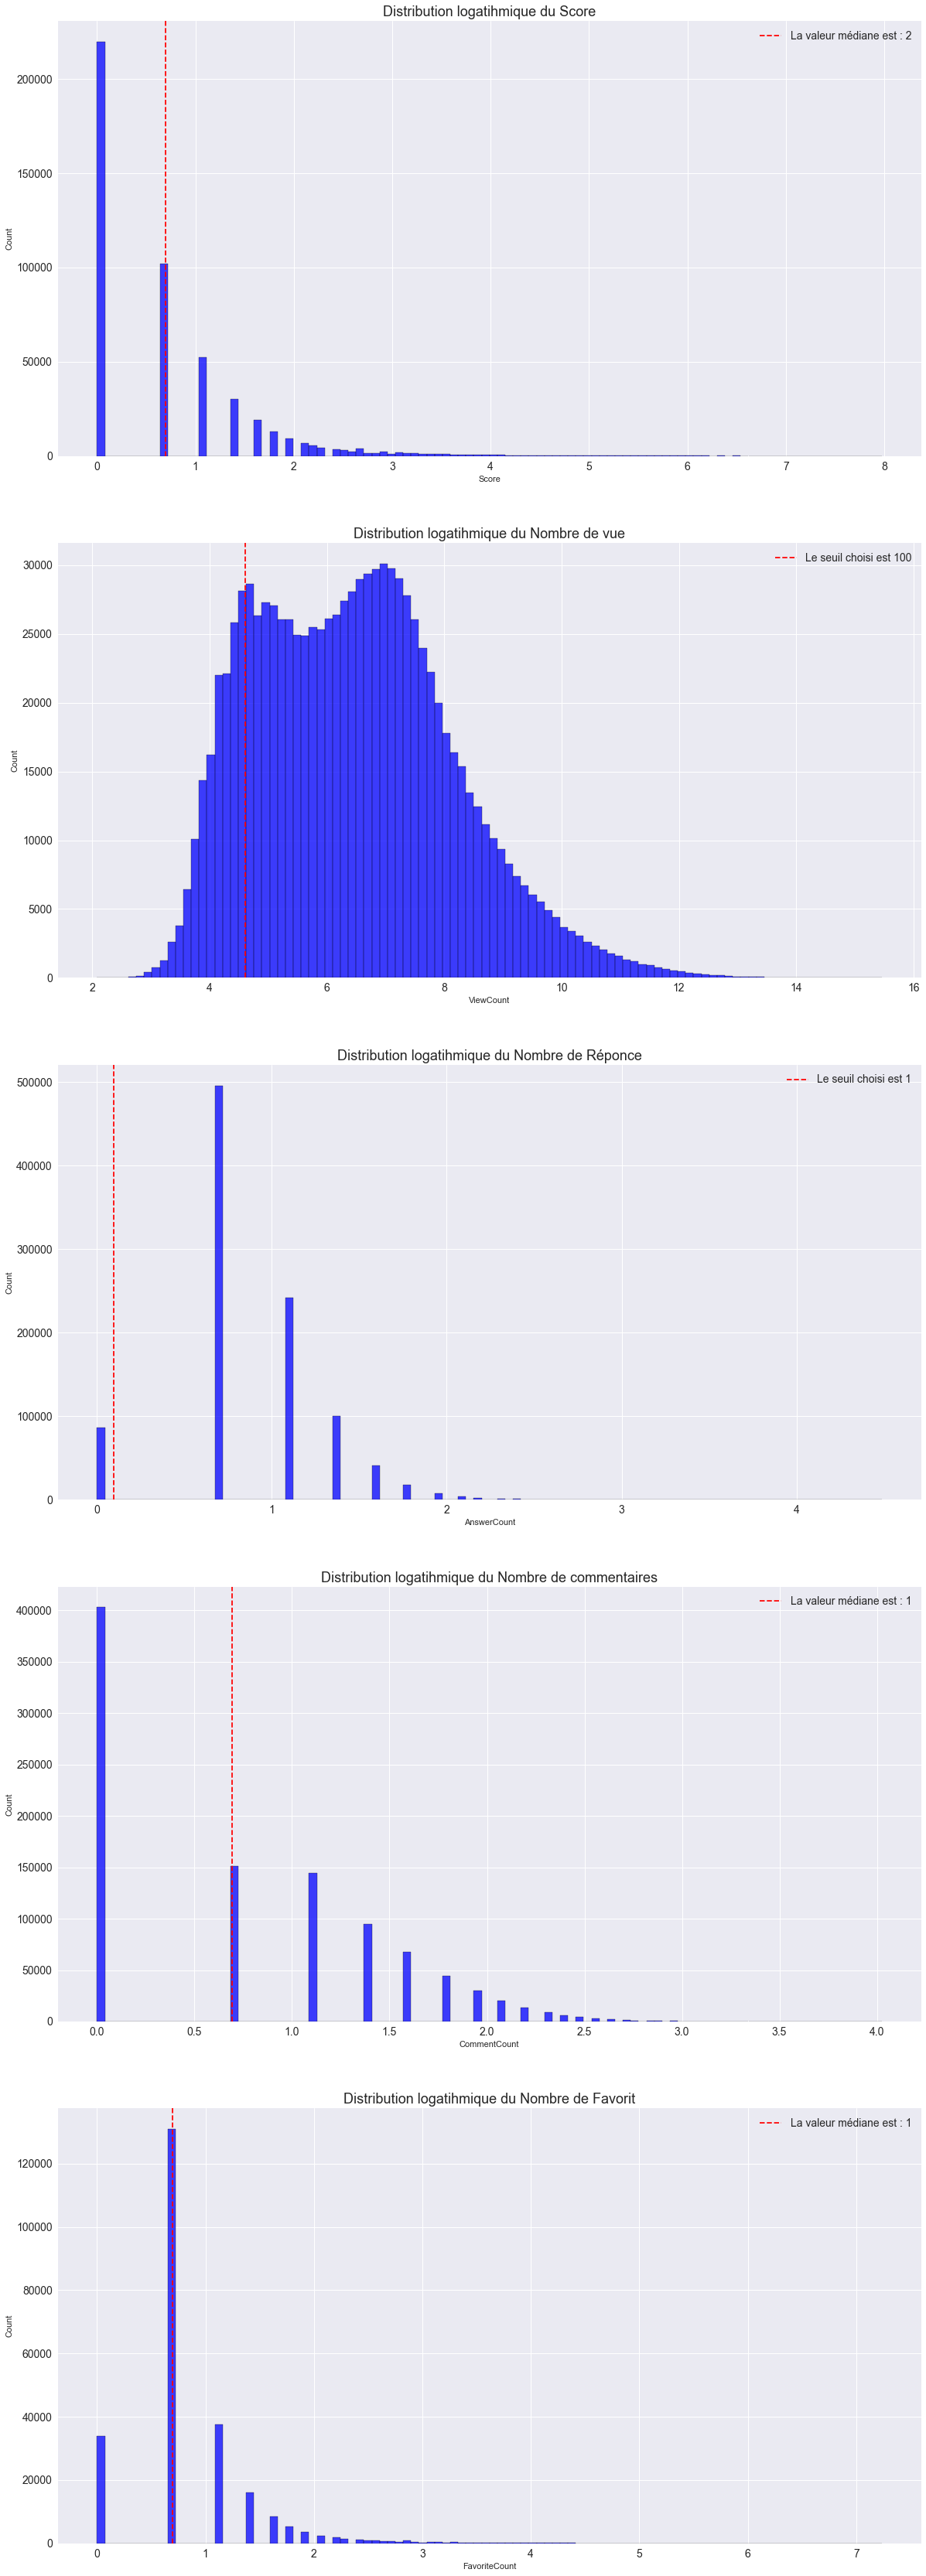

In [10]:
fig = plt.figure(figsize=(20, 12*5))

plt.subplot(511)
sns.histplot(np.log(postXML1[postXML1['Score'] > 0]['Score']), bins=100, color="blue")
plt.title("Distribution logatihmique du Score", fontsize=18)
plt.axvline(np.log(postXML1[postXML1['Score'] > 0]['Score']).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1[postXML['Score'] > 0]['Score'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(512)
sns.histplot(np.log(postXML['ViewCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de vue", fontsize=18)
plt.axvline(math.log(100), color="r", linestyle='--', label="Le seuil choisi est 100")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(513)
sns.histplot(np.log(postXML['AnswerCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Réponse", fontsize=18)
plt.axvline(math.log(1.1), color="r", linestyle='--', label="Le seuil choisi est 1")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(514)
sns.histplot(np.log(postXML['CommentCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de commentaires", fontsize=18)
plt.axvline(np.log(postXML['CommentCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML['CommentCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(515)
sns.histplot(np.log(postXML['FavoriteCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Favorit", fontsize=18)
plt.axvline(np.log(postXML['FavoriteCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML['FavoriteCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


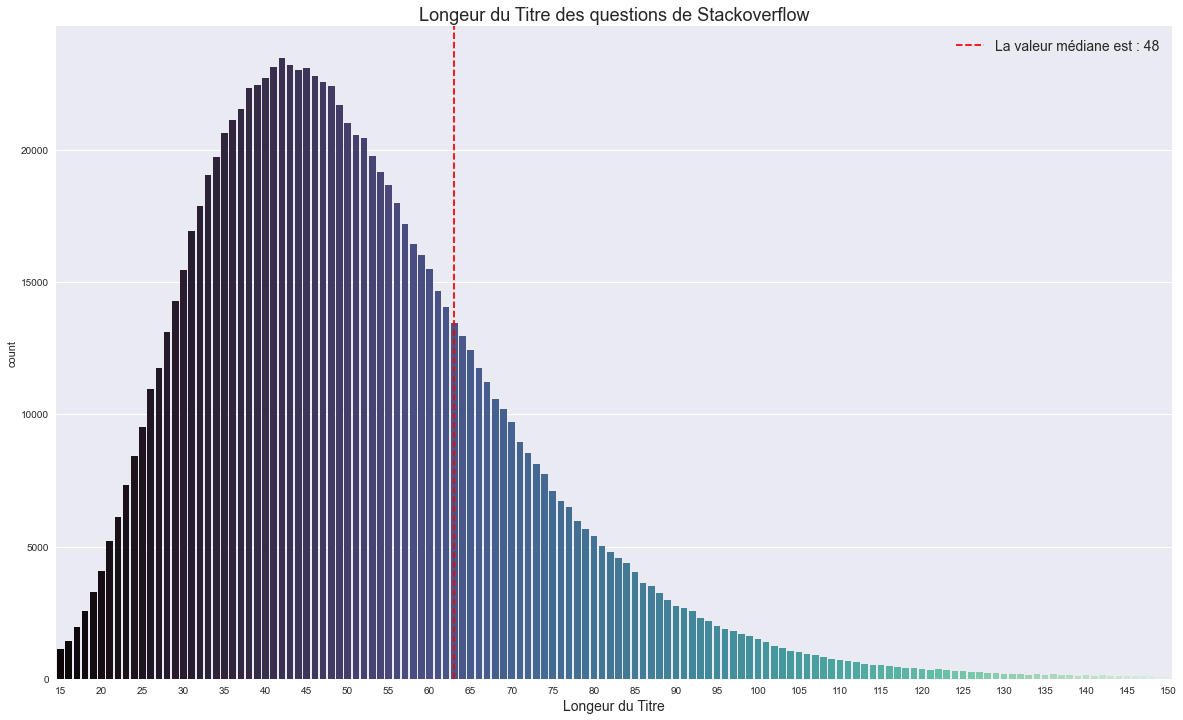

In [11]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML.Title.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(postXML1.Title.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1.Title.str.len().median()))
ax.set_xlabel("Longeur du Titre", fontsize=14)
plt.title("Longeur du Titre des questions de Stackoverflow",
          fontsize=18)
plt.legend(fontsize=14)
plt.show()


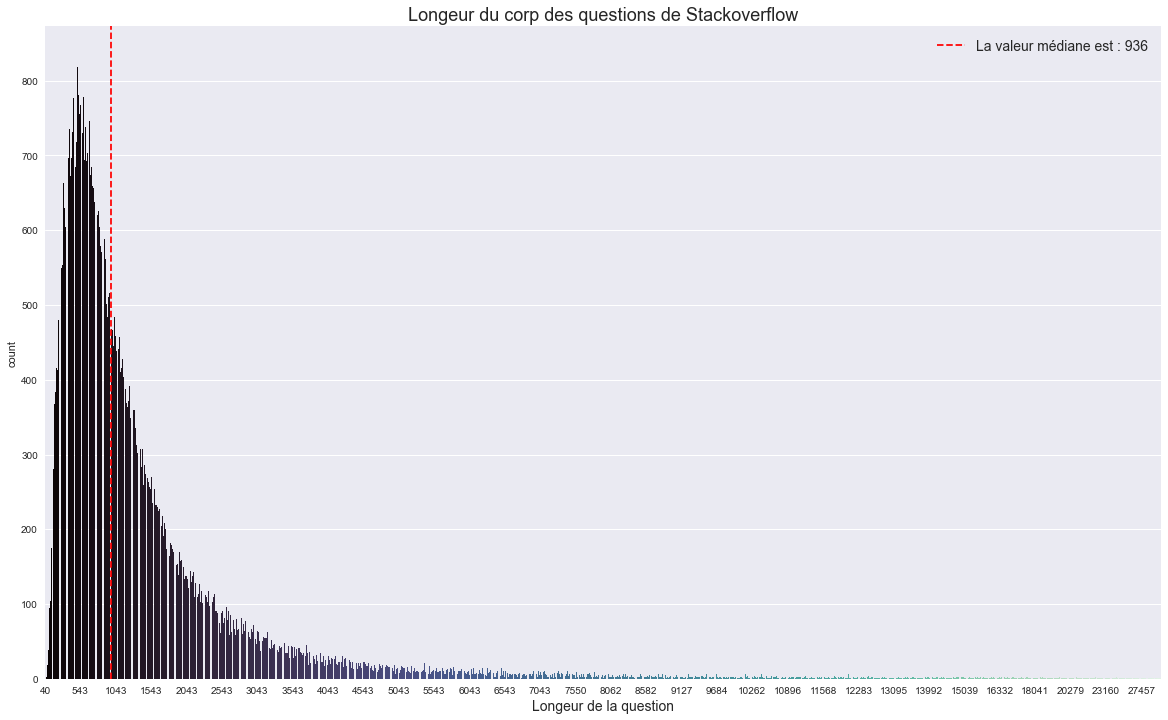

In [12]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML1.Body.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 500))
plt.axvline(postXML1.Body.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML1.Body.str.len().median()))
ax.set_xlabel("Longeur de la question", fontsize=14)
plt.title("Longeur du corp des questions de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


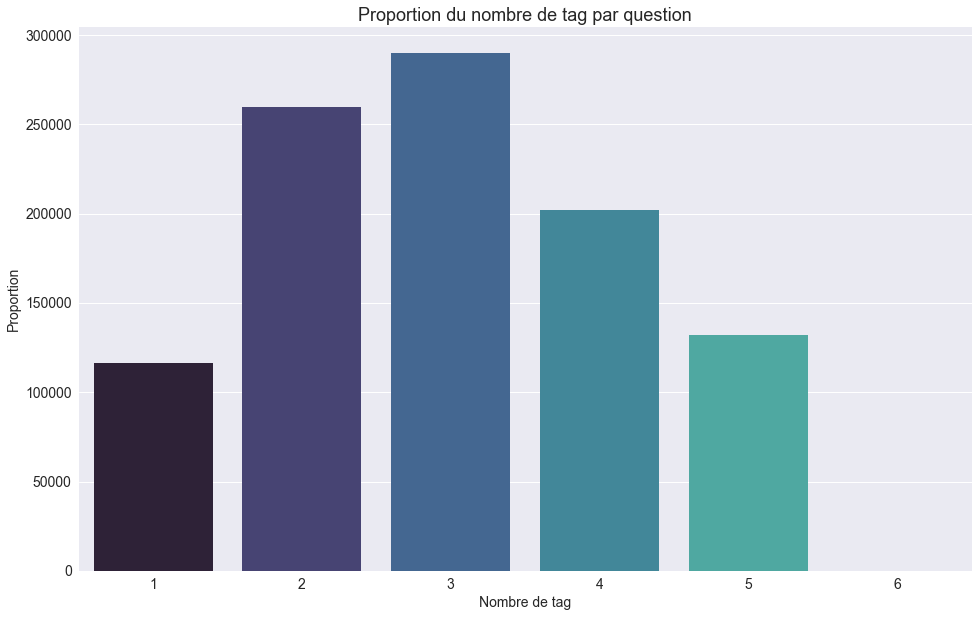

In [13]:
fig = plt.figure(figsize=(16, 10))
sns.countplot(postXML1['Tags_list'].str.len(), palette="mako")
plt.title("Proportion du nombre de tag par question", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Nombre de tag", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.show()

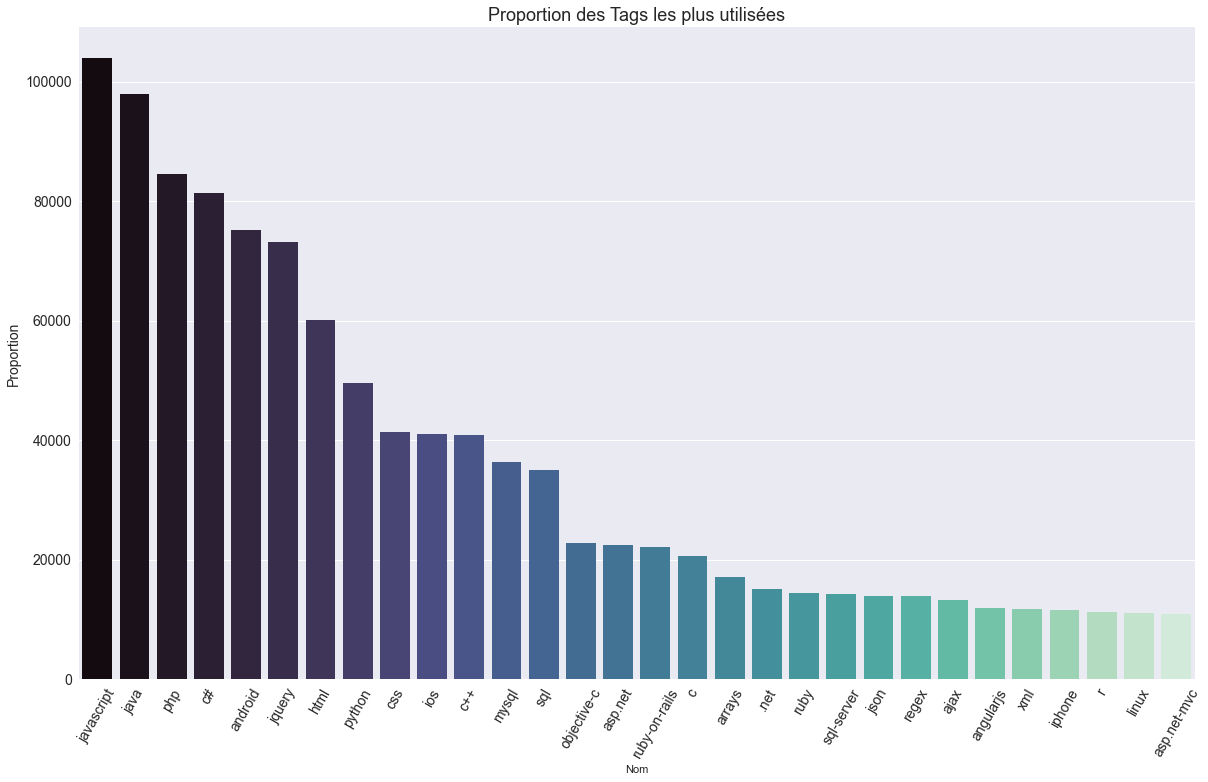

In [14]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x=Tags_list[:30]['Nom'], y=Tags_list[:30]['Nombre'], palette="mako")
plt.title("Proportion des Tags les plus utilisées", fontsize=18)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.show()


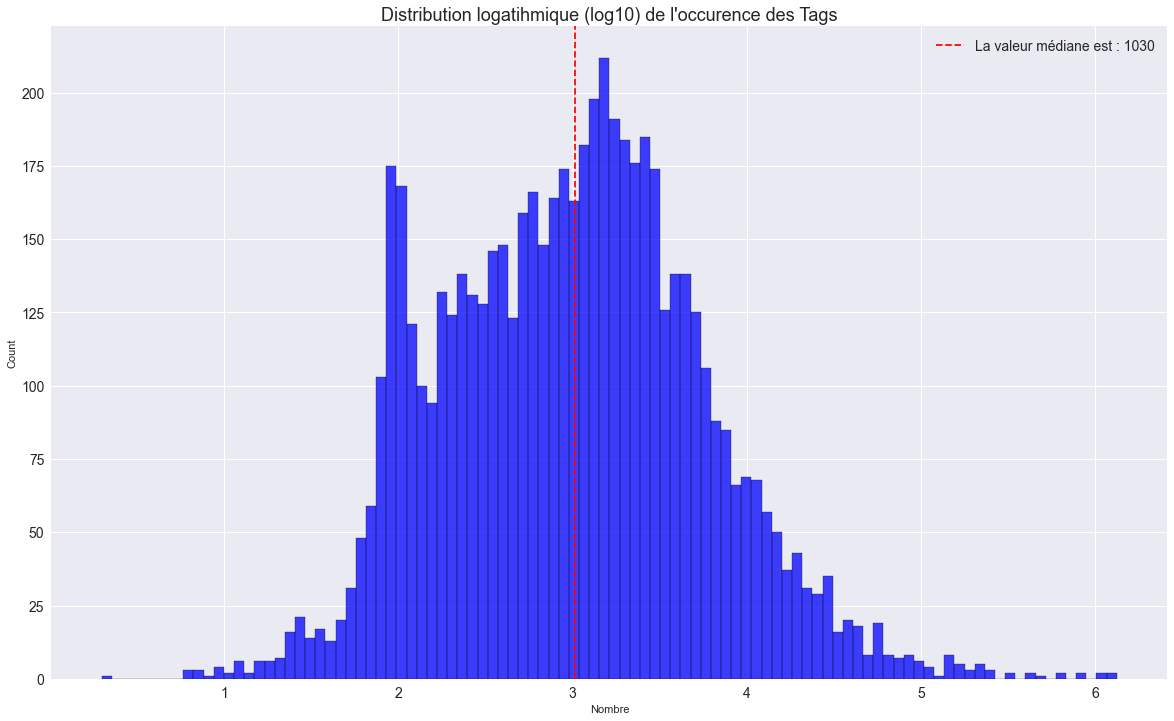

In [46]:
fig = plt.figure(figsize=(20, 12))
sns.histplot(np.log10(Tags_list['Nombre']), bins=100, color="blue")
plt.title("Distribution logatihmique (log10) de l'occurence des Tags",
          fontsize=18)
plt.axvline(np.log10(Tags_list['Nombre']).median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(Tags_list['Nombre'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

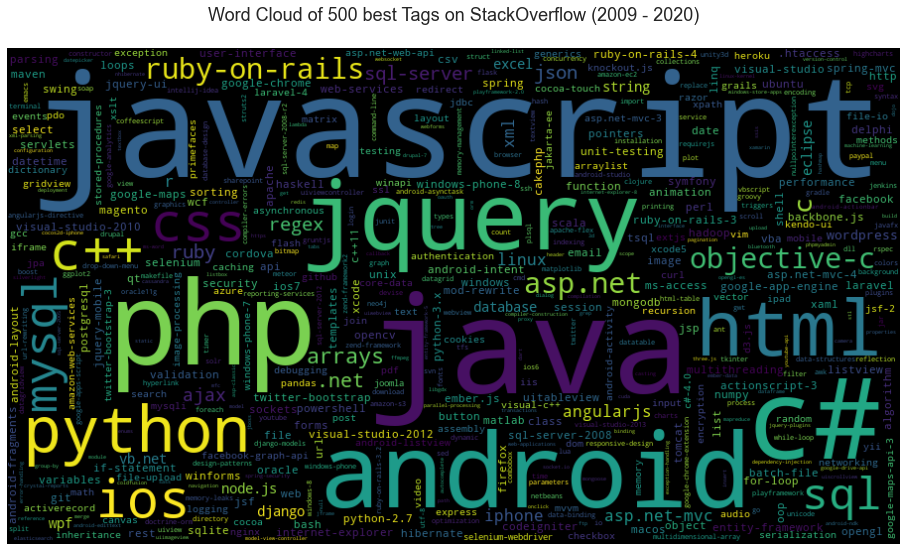

In [16]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(Tags_list.set_index('Nom').to_dict()['Nombre'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

### Filtrage des questions et tags

In [17]:
shape_avant = Tags_list.shape[0]
# Tags_list = Tags_list[Tags_list['Nombre'] >= 1000]
Tags_list = Tags_list[:100]
Tags_name_list = Tags_list['Nom'].to_list()
print('le nombre de Tags unique est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_avant)*100))

le nombre de Tags unique est passé de 29021 à 100 soit on à perdue 99.66%


In [18]:
shape_avant = postXML1.shape[0]
postXML1 = postXML1[postXML1['AnswerCount'] >= 1]
postXML1 = postXML1[postXML1['ViewCount'] >= 100]
postXML1['Tags_list'] = postXML1['Tags_list'].apply(clean_tags).str.join(' ')
postXML1 = postXML1[postXML1['Tags_list'] != '']
print('le nombre de question est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, postXML1.shape[0], (1-postXML1.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 665888 soit on à perdue 33.41%


### Nettoyage des questions

In [19]:
postXML1['Body_clean'] = postXML1['Body'].apply(clean_html_body)
postXML1['Text'] = (postXML1['Body_clean'] + " " + postXML1['Title']).apply(post_to_words)
postXML1['Text_len'] = postXML1['Text'].str.split().str.len()
borne_text = (postXML1['Text_len'].quantile(0.75) - postXML1['Text_len'].quantile(0.25))*2 + postXML1['Text_len'].quantile(0.75)

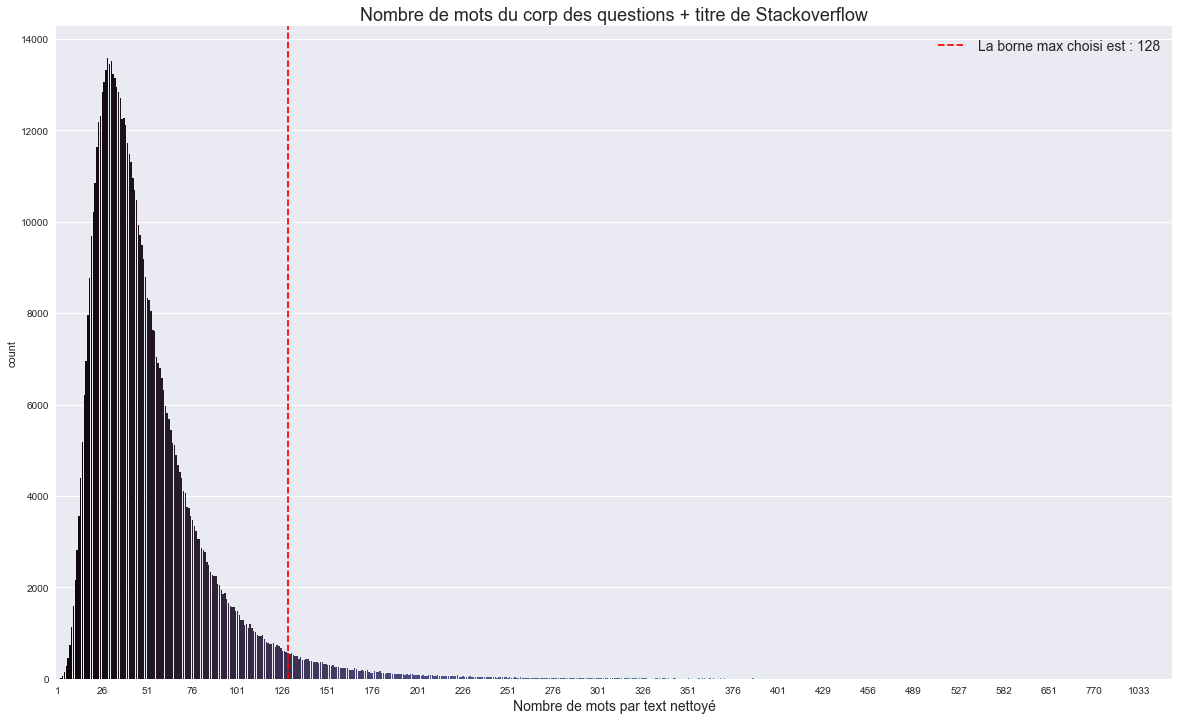

In [20]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML1['Text_len'], palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plt.axvline(borne_text,
            color="r", linestyle='--',
            label="La borne max choisi est : {:.0f}".format(borne_text))
ax.set_xlabel("Nombre de mots par text nettoyé", fontsize=14)
plt.title("Nombre de mots du corp des questions + titre de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [21]:
postXML1 = postXML1[postXML1['Text_len'] < borne_text]
print('le nombre de question est passé de {} à {} soit on à perdue {:.2f}%'.format(shape_avant, postXML1.shape[0], (1-postXML1.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 643026 soit on à perdue 35.70%


In [22]:
count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
bag_of_word = count_vect.fit_transform(postXML1['Text'])
word_sum = pd.DataFrame(bag_of_word.sum(axis=0).T, index=count_vect.get_feature_names_out(), columns=['freq']).sort_values(by='freq', ascending=False)['freq']
word_sum_log = np.log10(word_sum)
borne = (word_sum_log.quantile(0.75) - word_sum_log.quantile(0.25))*2 + word_sum_log.quantile(0.75)
vocabulary = word_sum_log[word_sum_log < borne].index.to_numpy()

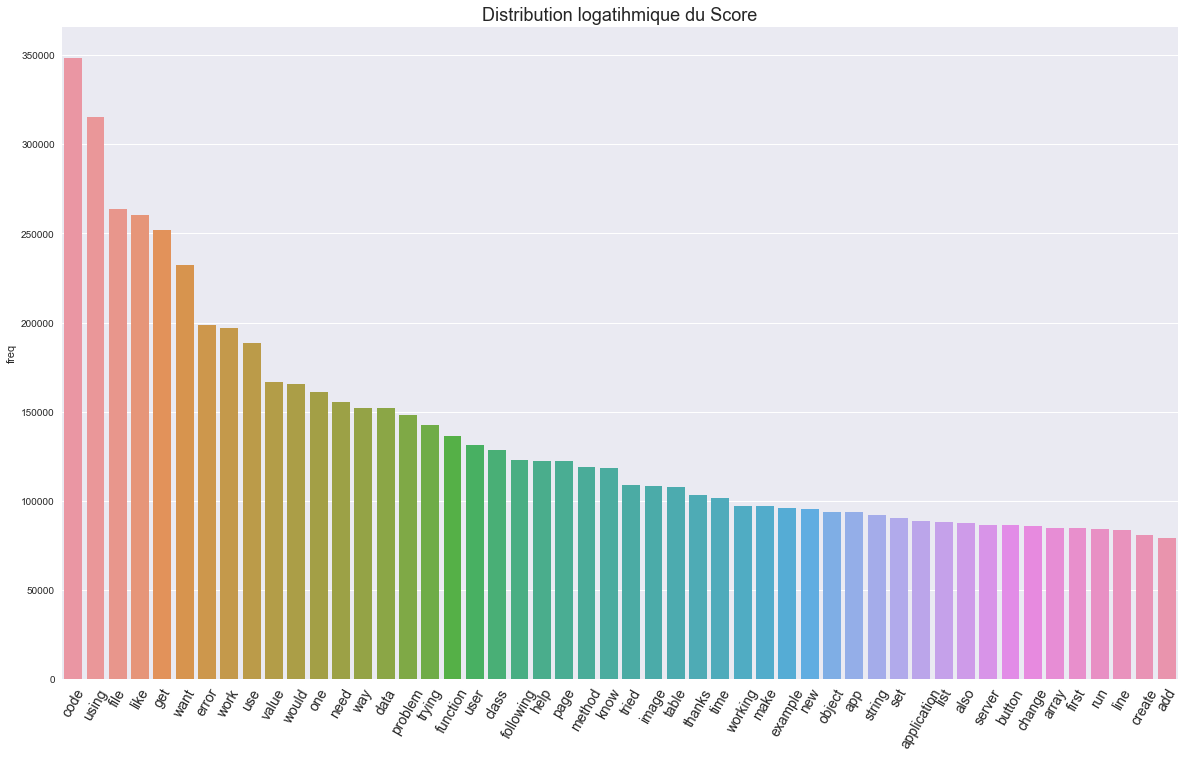

In [23]:
plt.figure(figsize=(20, 12))
plt.title("Distribution logatihmique du Score", fontsize=18)
sns.barplot(x=word_sum.index[:50], y=word_sum[:50])
plt.xticks(fontsize=14, rotation=60)
plt.show()

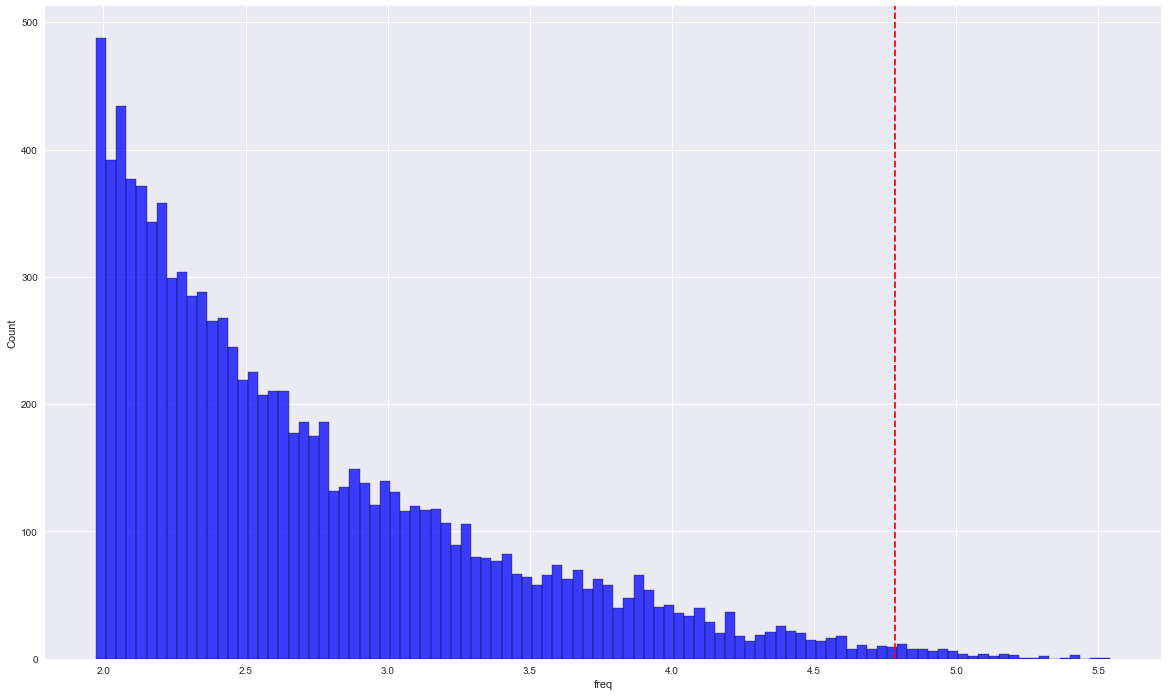

In [24]:
plt.figure(figsize=(20, 12))
sns.histplot(word_sum_log, color="blue", bins=100)
plt.axvline(borne,
            color="r", linestyle='--',
            label="La borne interquartile est : {:.2f}".format(borne))
plt.show()

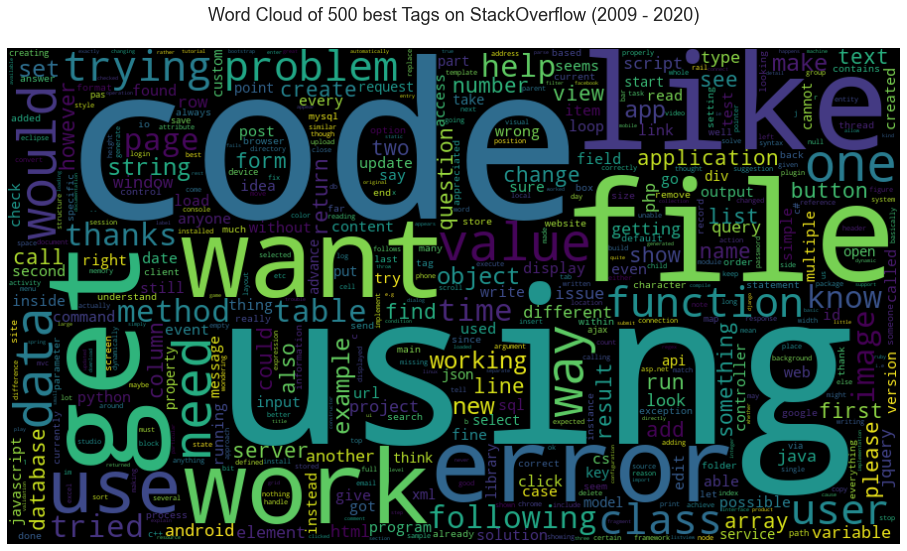

In [25]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log.to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

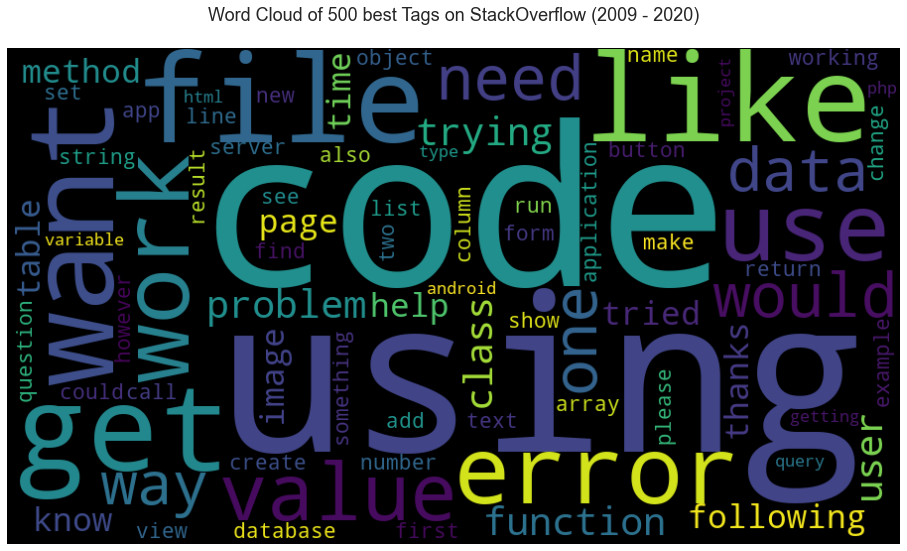

In [26]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[word_sum_log > borne].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

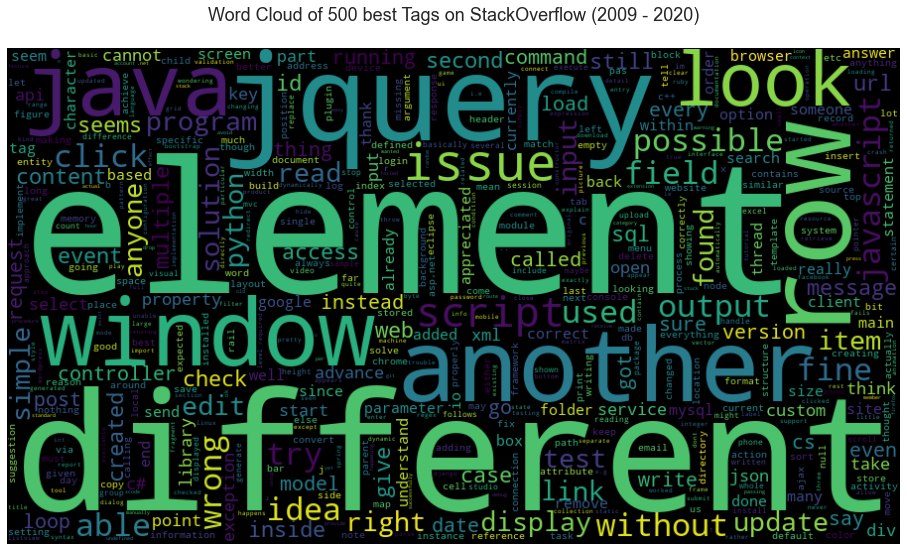

In [27]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[word_sum_log < borne].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

In [28]:
postXML1[["Text", "Tags_list"]].to_csv("Data/Posts_Clean_1.csv")
np.save("Data/Vocabulary.npy", vocabulary)

## Nettoyage a la chaine

In [8]:
postMin = 14
postMax = 22
start_time = time.time()
for it in range(postMin, postMax+1):
    postXML = pd.read_csv('Data/PostsXML_'+str(it)+'.csv', index_col=0)
    postXML['Tags_list'] = postXML['Tags'].apply(split_tags)
    tags_binarizer = MultiLabelBinarizer(sparse_output=True)
    Tags = tags_binarizer.fit_transform(postXML.Tags_list)
    Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)
    shape_tags = Tags_list.shape[0]
    Tags_list = Tags_list[Tags_list['Nombre'] >= 100]
    Tags_name_list = Tags_list['Nom'].to_list()
    shape_avant = postXML.shape[0]
    postXML = postXML[postXML['AnswerCount'] >= 1]
    postXML = postXML[postXML['ViewCount'] >= 100]
    postXML['Tags_list'] = postXML['Tags_list'].apply(clean_tags).str.join(' ')
    postXML = postXML[postXML['Tags_list'] != '']
    postXML['Body_clean'] = postXML['Body'].apply(clean_html_body)
    postXML['Text'] = (postXML['Body_clean'] + " " + postXML['Title']).apply(post_to_words)
    interval = time.time() - start_time
    print('Traitement du text effectué    {h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
    postXML['Text_len'] = postXML['Text'].str.split().str.len()
    borne_text = (postXML['Text_len'].quantile(0.75) - postXML['Text_len'].quantile(0.25))*2 + postXML['Text_len'].quantile(0.75)
    postXML = postXML[postXML['Text_len'] < borne_text]
    print('Tags unique: de {} à {} soit {:.2f}% en moins'.format(shape_tags, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_tags)*100) + \
          'question: de {} à {} soit {:.2f}% en moins'.format(shape_avant, postXML.shape[0], (1-postXML.shape[0]/shape_avant)*100))
    postXML[["Text", "Tags_list"]].to_csv('Data/Posts_Clean_'+str(it)+'.csv')
    interval = time.time() - start_time
    print('le post {} est enregistré      {h}:%.3f temps passé'.format(it, h = int(interval//60)) % (interval%60))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    16:37.634 temps passé
Tags unique: de 35335 à 2787 soit 92.11% en moinsquestion: de 1000000 à 601846 soit 39.82% en moins
le post 14 est enregistré      16:48.923 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    33:16.943 temps passé
Tags unique: de 36106 à 2771 soit 92.33% en moinsquestion: de 1000000 à 580579 soit 41.94% en moins
le post 15 est enregistré      33:27.167 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    49:25.502 temps passé
Tags unique: de 36569 à 2817 soit 92.30% en moinsquestion: de 1000000 à 556467 soit 44.35% en moins
le post 16 est enregistré      49:36.699 temps passé
Traitement du text effectué    65:20.596 temps passé
Tags unique: de 36534 à 2776 soit 92.40% en moinsquestion: de 1000000 à 531438 soit 46.86% en moins
le post 17 est enregistré      65:30.785 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    80:33.910 temps passé
Tags unique: de 36514 à 2715 soit 92.56% en moinsquestion: de 1000000 à 495852 soit 50.41% en moins
le post 18 est enregistré      80:44.715 temps passé
Traitement du text effectué    94:27.064 temps passé
Tags unique: de 37410 à 2795 soit 92.53% en moinsquestion: de 1000000 à 448518 soit 55.15% en moins
le post 19 est enregistré      94:35.920 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    106:47.766 temps passé
Tags unique: de 37758 à 2774 soit 92.65% en moinsquestion: de 1000000 à 392055 soit 60.79% en moins
le post 20 est enregistré      106:55.074 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    114:44.262 temps passé
Tags unique: de 39184 à 2881 soit 92.65% en moinsquestion: de 1000000 à 235480 soit 76.45% en moins
le post 21 est enregistré      114:48.599 temps passé
Traitement du text effectué    118:26.298 temps passé
Tags unique: de 39906 à 2830 soit 92.91% en moinsquestion: de 978327 à 89782 soit 90.82% en moins
le post 22 est enregistré      118:28.347 temps passé


## Regroupement des Posts

In [8]:
count = 23
posts = pd.DataFrame(columns=['Text', 'Tags_list'])
for it in range(1, count):
    posts_clean = pd.read_csv('Data/Posts_Clean_{}.csv'.format(it), index_col=0)
    posts = posts.append(posts_clean, ignore_index=True)
    print('fichier N°{} ajouté'.format(it))

fichier N°1 ajouté
fichier N°2 ajouté
fichier N°3 ajouté
fichier N°4 ajouté
fichier N°5 ajouté
fichier N°6 ajouté
fichier N°7 ajouté
fichier N°8 ajouté
fichier N°9 ajouté
fichier N°10 ajouté
fichier N°11 ajouté
fichier N°12 ajouté
fichier N°13 ajouté
fichier N°14 ajouté
fichier N°15 ajouté
fichier N°16 ajouté
fichier N°17 ajouté
fichier N°18 ajouté
fichier N°19 ajouté
fichier N°20 ajouté
fichier N°21 ajouté
fichier N°22 ajouté


In [9]:
posts = posts.astype({'Text': 'string', 'Tags_list': 'string'})
drop_list = []
for i, elem in enumerate(posts.Text):
    if type(elem) != str:
        drop_list.append(i)
for i, elem in enumerate(posts.Tags_list):
    if type(elem) != str:
        drop_list.append(i)
print('il y a {} questions sans tags ou question'.format(len(drop_list)))
posts.drop(drop_list, inplace=True)
posts['Tags_list'] = posts['Tags_list'].str.split()
tags_binarizer = MultiLabelBinarizer(sparse_output=True)
Tags = tags_binarizer.fit_transform(posts.Tags_list)
Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)
borne_tag = Tags_list[:200]['Nombre'].min()

il y a 85 questions sans tags ou question


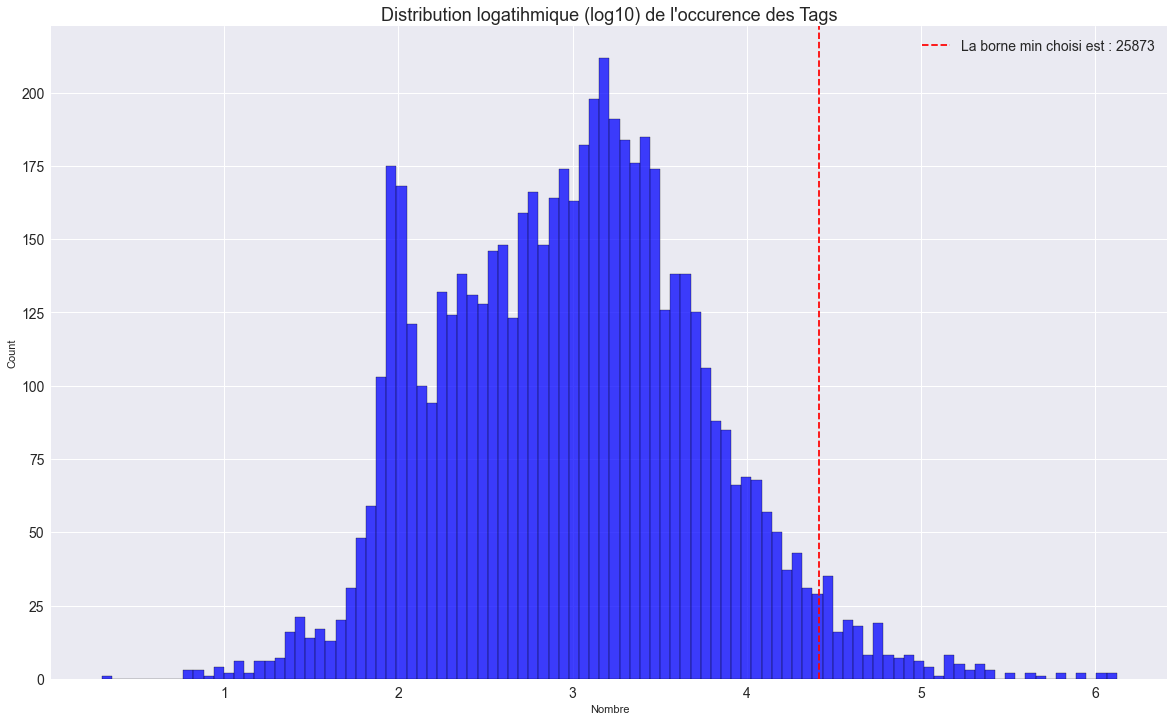

In [35]:
num = 100000
fig = plt.figure(figsize=(20, 12))
sns.histplot(np.log10(Tags_list['Nombre']), bins=100, color="blue")
plt.title("Distribution logatihmique (log10) de l'occurence des Tags",
          fontsize=18)
plt.axvline(np.log10(borne_tag),
            color="r", linestyle='--',
            label="La borne min choisi est : {:.0f}".format(borne_tag))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

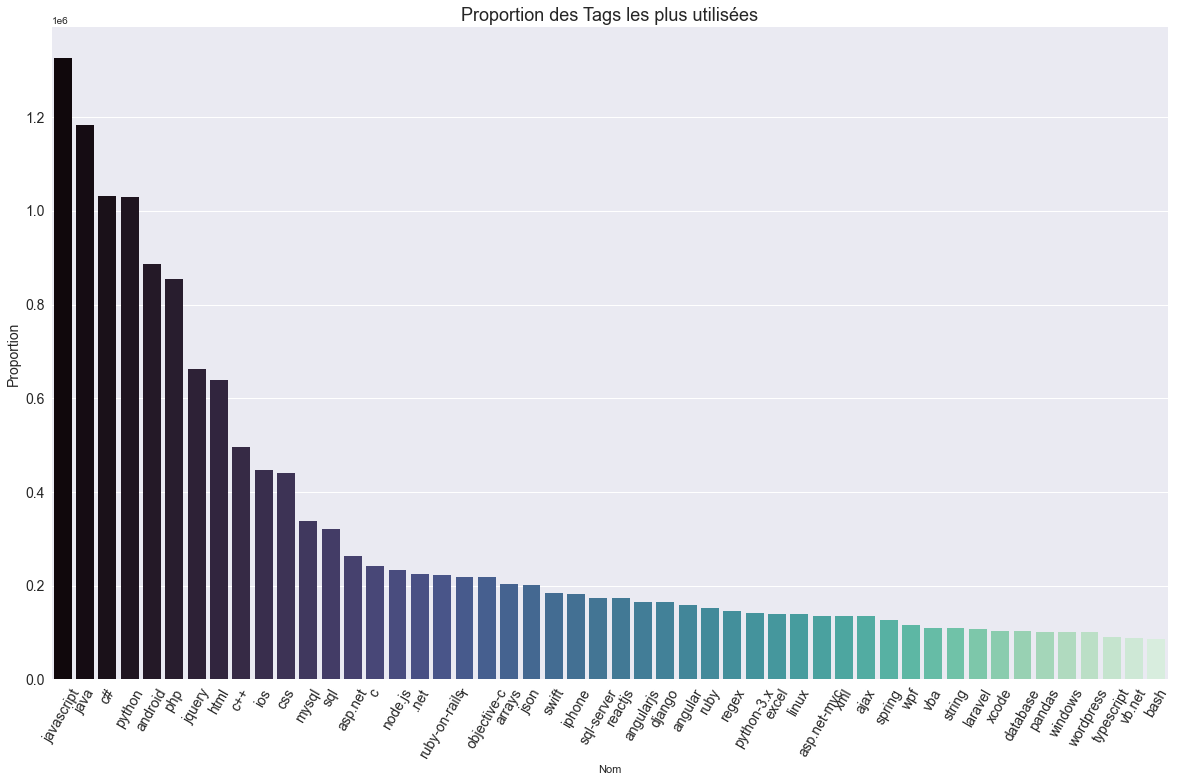

In [9]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x=Tags_list[:50]['Nom'], y=Tags_list[:50]['Nombre'], palette="mako")
plt.title("Proportion des Tags les plus utilisées", fontsize=18)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.show()

In [36]:
shape_tags = Tags_list.shape[0]
Tags_list = Tags_list[Tags_list['Nombre'] >= borne_tag]
Tags_name_list = Tags_list['Nom'].to_list()
shape_avant = posts.shape[0]
posts['Tags_list'] = posts['Tags_list'].apply(clean_tags).str.join(' ')
posts = posts[posts['Tags_list'] != '']
print('Tags unique: de {} à {} soit {:.2f}% en moins - '.format(shape_tags, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_tags)*100) + \
      'question: de {} à {} soit {:.2f}% en moins'.format(shape_avant, posts.shape[0], (1-posts.shape[0]/shape_avant)*100))

Tags unique: de 6030 à 200 soit 96.68% en moins - question: de 13456195 à 12018607 soit 10.68% en moins


In [9]:
count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=50000)
bag_of_word = count_vect.fit_transform(posts['Text'])
word_sum = pd.DataFrame(bag_of_word.sum(axis=0).T, index=count_vect.get_feature_names_out(), columns=['freq']).sort_values(by='freq', ascending=False)['freq']
del bag_of_word
word_sum_log: pd.DataFrame  = pd.DataFrame(np.log10(word_sum))
seuil = 8
vocabulary = word_sum[seuil:].index.to_numpy()

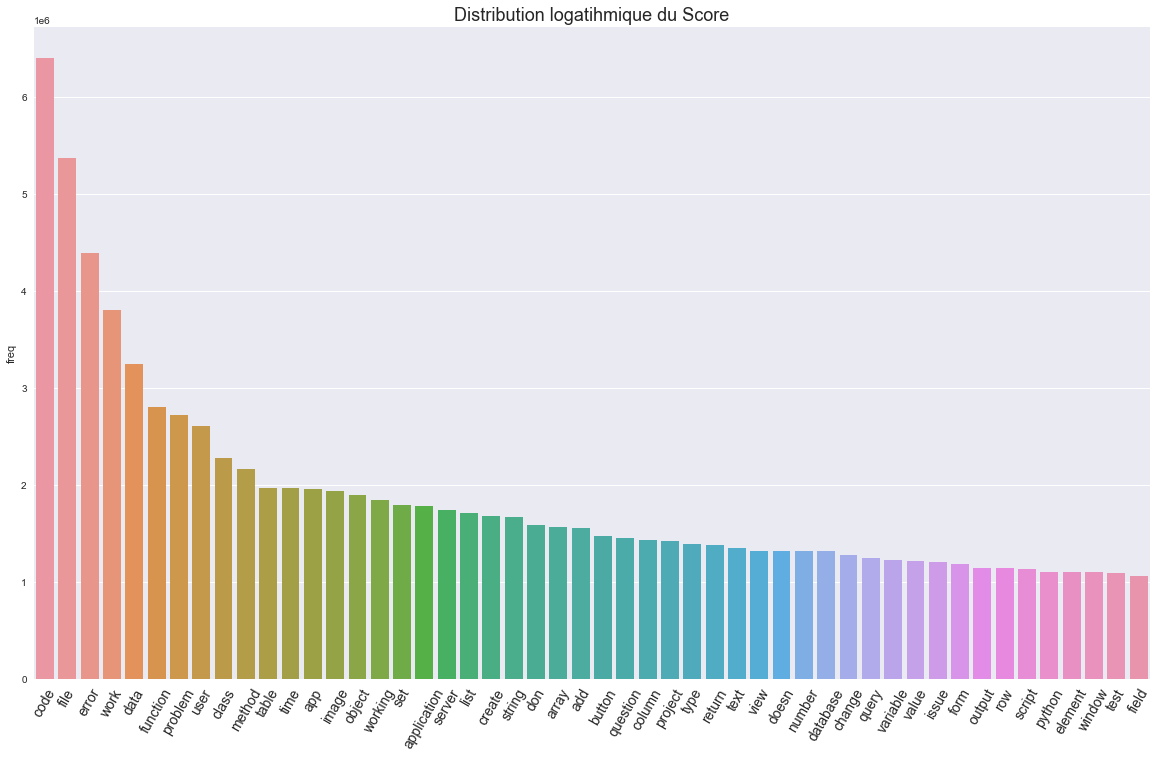

In [10]:
plt.figure(figsize=(20, 12))
plt.title("Distribution logatihmique du Score", fontsize=18)
sns.barplot(x=word_sum.index[:50], y=word_sum[:50])
plt.xticks(fontsize=14, rotation=60)
plt.show()

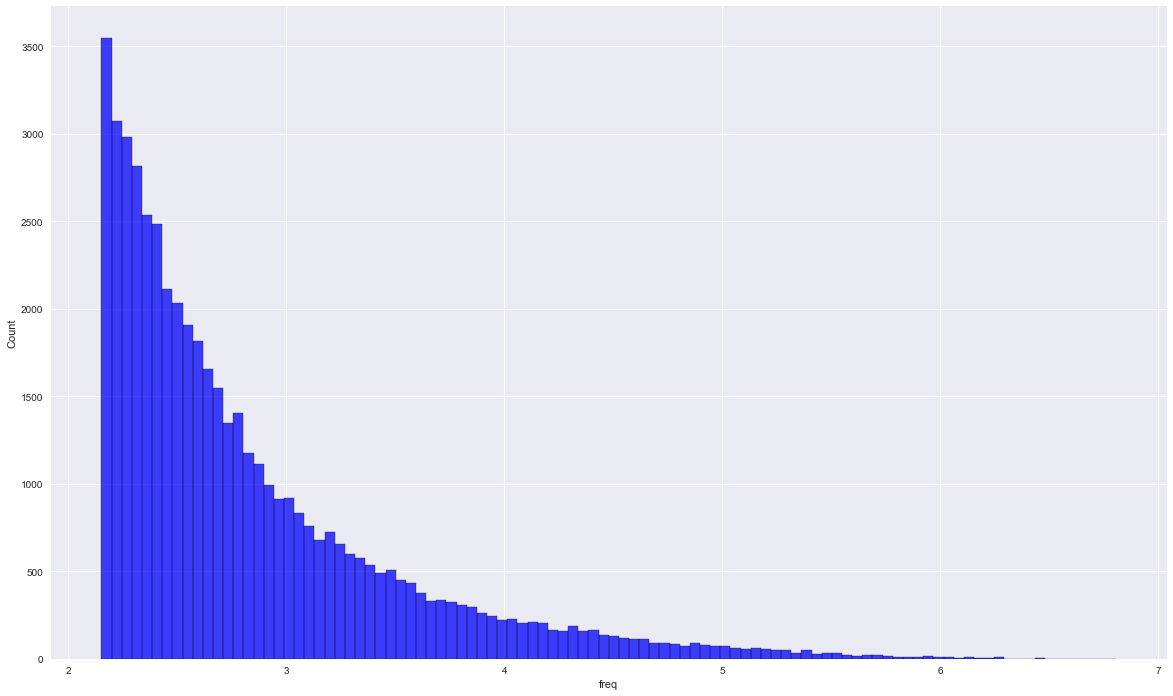

In [28]:
plt.figure(figsize=(20, 12))
sns.histplot(word_sum_log, color="blue", bins=100)
plt.show()

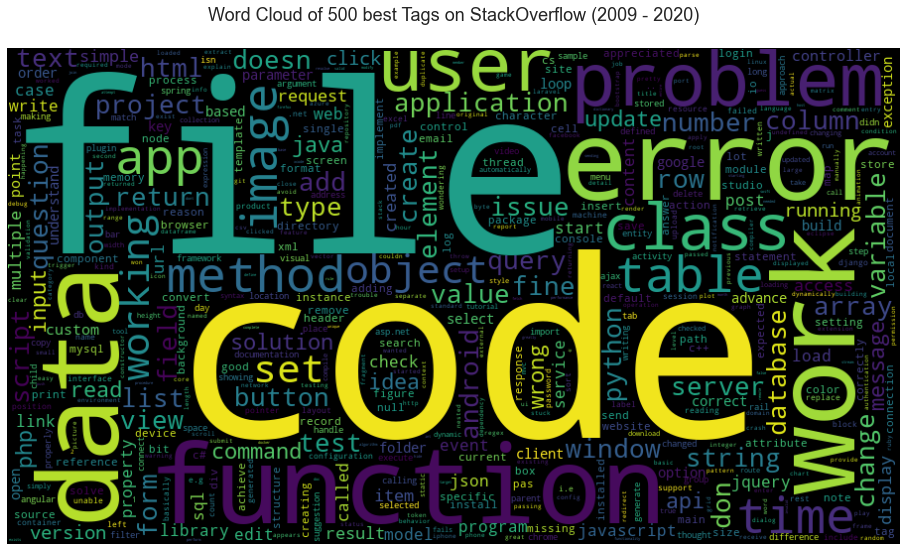

In [22]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log.to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

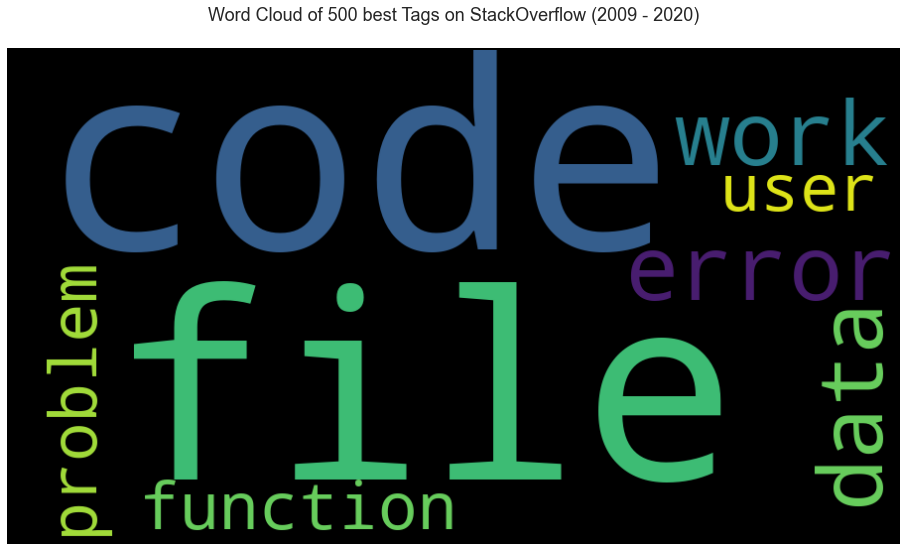

In [32]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[:seuil].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

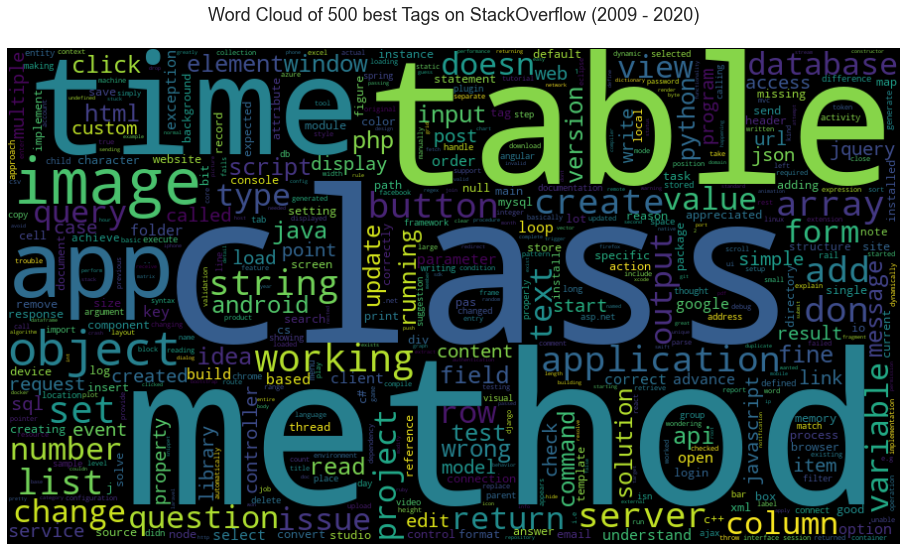

In [33]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum_log[seuil:].to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2020)\n",
          fontsize=18)
plt.show()

In [34]:
posts[["Text", "Tags_list"]].to_csv("Data/Posts_Clean_Full.csv")
np.save("Data/Vocabulary.npy", vocabulary)